# ADMM Example

## Setup

In [1]:
using Suppressor
using BM3D
using Images: assess_psnr
using MIRT: jim
include("admm.jl")
include("load_fastmri_data.jl")
include("system_ops.jl")
include("create_sampling_mask.jl")
include("utils.jl")
include("primal.jl")
@suppress include("dncnn.jl") # Suppress weight printing

# Create a single Julia function for calling nlmeans
function nlMeans(img::Array{Float32,2}, h::Number = 3)
    
    pyimg = np.uint8(reinterpret(UInt8, noisyImg)) # Convert julia image to np.uint8 array
    img_denoised = cv.fastNlMeansDenoising(pyimg, h=h)
end

# Useful to flip images
function rev(img::AbstractArray{T, 2}) where T
    img[end:-1:1, end:-1:1]
end

rev (generic function with 1 method)

In [2]:
# using Pkg; Pkg.add("LinearMapsAA")

# Create an undersampled data set

In [23]:
# Load a fully sampled image
fName = "file1000000.h5" # File name
fName = joinpath(dirname(pwd()), "data", fName) # Full file name
img = abs.(load_fastmri_data(fName))
img = img / max(img...)
(M,N) = size(img)

(368, 640)

In [24]:
max(img...)

1.0f0

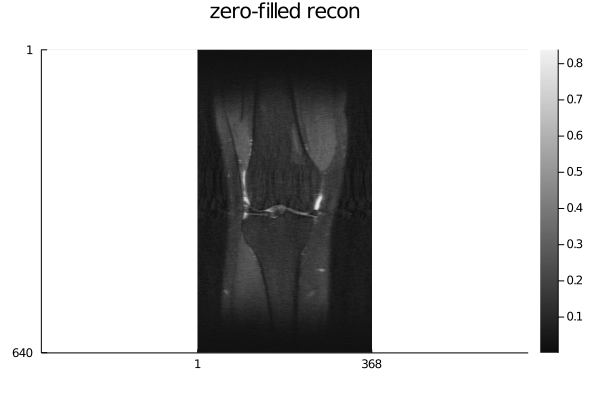

In [5]:
# Specify acceleration factor for sampling mask
R = 4
M_us = Int(round(M/R)) # Undersampled number of points
# Create a 1D random undersampling mask
sampleMask = create_sampling_mask(M, N, R, seed=0)
# Create linear map, A, that describes the MRI system model
A = LinearMapAA(x -> sys_forw(x, sampleMask), x -> sys_adj(x,sampleMask), (M_us*N, M*N))
# Apply model to image -> generate an undersampled k-space
y = A*img[:]
# Applying adjoint model to k-space reconstructs the image (poorly)
x0 = abs.(reshape(A'*y,M,N))
j2 = jim(rev(x0),title="zero-filled recon")

In [15]:
x1 = dncnn_denoise(float32.(x0))

368×640 Array{Float32,2}:
 0.0199165   0.0197916   0.0313804  …  0.0227049   0.0201499  0.016771
 0.0174537   0.0161727   0.0283819     0.0229532   0.023631   0.0202101
 0.0144759   0.0160479   0.0251934     0.0211864   0.0210654  0.0214429
 0.0161367   0.021003    0.0244543     0.0192755   0.0178418  0.0159759
 0.0217624   0.0233925   0.0213805     0.0182724   0.0173372  0.0117208
 0.0249543   0.0171104   0.0168229  …  0.0161218   0.0181971  0.0153052
 0.021889    0.0091333   0.0170775     0.0116523   0.0164426  0.0209403
 0.0172097   0.00836591  0.0203137     0.00890483  0.0145876  0.0208976
 0.0158762   0.0131528   0.0201715     0.0113578   0.0144669  0.0171379
 0.0174178   0.0156647   0.0162947     0.0147129   0.014938   0.0151494
 0.0192884   0.013084    0.013737   …  0.013002    0.0155967  0.0155861
 0.021934    0.00934231  0.013667      0.00791272  0.0159862  0.016867
 0.0261373   0.00808412  0.0134449     0.00744747  0.0171402  0.0181183
 ⋮                                  ⋱   

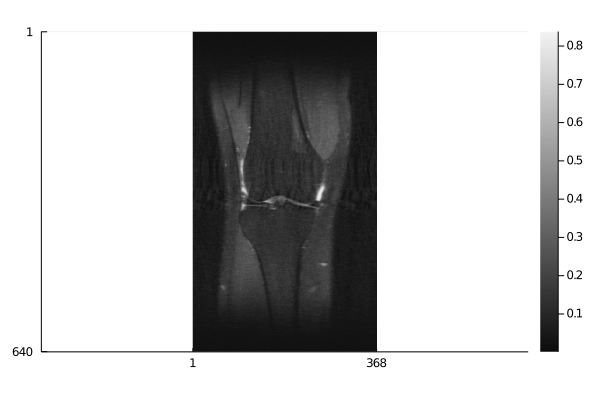

In [17]:
jim(rev(x1))

In [12]:
float32.(x0)

368×640 Array{Float32,2}:
 0.0199165   0.0197916   0.0313804  …  0.0227049   0.0201499  0.016771
 0.0174537   0.0161727   0.0283819     0.0229532   0.023631   0.0202101
 0.0144759   0.0160479   0.0251934     0.0211864   0.0210654  0.0214429
 0.0161367   0.021003    0.0244543     0.0192755   0.0178418  0.0159759
 0.0217624   0.0233925   0.0213805     0.0182724   0.0173372  0.0117208
 0.0249543   0.0171104   0.0168229  …  0.0161218   0.0181971  0.0153052
 0.021889    0.0091333   0.0170775     0.0116523   0.0164426  0.0209403
 0.0172097   0.00836591  0.0203137     0.00890483  0.0145876  0.0208976
 0.0158762   0.0131528   0.0201715     0.0113578   0.0144669  0.0171379
 0.0174178   0.0156647   0.0162947     0.0147129   0.014938   0.0151494
 0.0192884   0.013084    0.013737   …  0.013002    0.0155967  0.0155861
 0.021934    0.00934231  0.013667      0.00791272  0.0159862  0.016867
 0.0261373   0.00808412  0.0134449     0.00744747  0.0171402  0.0181183
 ⋮                                  ⋱   

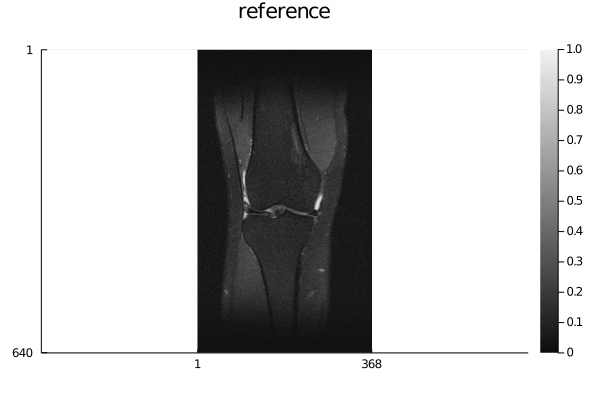

In [7]:
j1 = jim(abs.(rev(img)),title="reference")

In [18]:
x_hat = admm((z,η,μ) -> primal(z,η,μ,A,sampleMask,y), (x) -> dncnn_denoise(float32.(abs.(x))), 1, x0, niter=10)
x_hat = reshape(x_hat,M,N)

1

2

3

4

5

6

7

8

9

10

368×640 Array{Complex{Float64},2}:
  0.0201549+2.04798e-6im   0.0184894-6.3297e-6im   …   0.0160682+1.30636e-6im
  0.0174029-1.75206e-6im   0.0147476+1.06097e-6im      0.0209947+2.75258e-7im
  0.0135732-7.6682e-6im    0.0162894+5.1339e-6im       0.0234018-1.06344e-6im
  0.0152247-8.61271e-6im    0.024429-1.09544e-7im      0.0156924+1.25788e-6im
  0.0217388-3.20041e-6im   0.0275917-5.20019e-6im     0.00910736+2.715e-6im
  0.0258268+3.38193e-7im   0.0179047-3.23645e-6im  …   0.0136864+1.3243e-6im
  0.0230819-2.07083e-6im  0.00655751+3.43972e-7im      0.0214073+1.37127e-6im
  0.0184429-4.7024e-6im   0.00619614+2.15245e-6im       0.021953+3.14776e-6im
   0.016892-3.59336e-6im   0.0136622+4.48833e-6im      0.0181725+2.56179e-6im
   0.017557-1.79588e-6im   0.0181207+3.92079e-6im      0.0159634+1.11744e-6im
  0.0181578-1.26728e-6im   0.0157444-2.90033e-6im  …   0.0153428+3.76092e-6im
  0.0205351-1.92895e-7im   0.0106329-6.70951e-6im      0.0162536+8.55241e-6im
  0.0262353+1.49697e-6im  0.0076

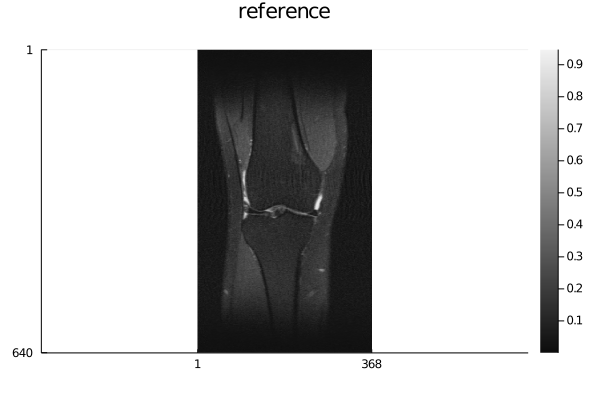

In [19]:
jim(abs.(rev(x_hat)),title="reference")

In [20]:
@show assess_psnr(x0, img) # PSNR
@show assess_psnr(x_hat, img) # PSNR

assess_psnr(x0, img) = 30.432749989688098
assess_psnr(x_hat, img) = 31.511489265477973


31.511489265477973

In [25]:
nlMeans(img)

LoadError: MethodError: no method matching nlMeans(::Array{Float32,2})
Closest candidates are:
  nlMeans(!Matched::Array{Normed{UInt8,8},2}) at In[1]:14
  nlMeans(!Matched::Array{Normed{UInt8,8},2}, !Matched::Number) at In[1]:14